In [1]:
import shutil
# loading data into python structures
try:
    shutil.rmtree(".data/dnd-cnn-split/train")
    shutil.rmtree("data/dnd-cnn-split/test")
except:
    pass

In [2]:
import os
# ensure directories exist
from pathlib import Path

Path("data/dnd-cnn-split/train/damage").mkdir(parents=True, exist_ok=True)
Path("data/dnd-cnn-split/train/no-damage").mkdir(parents=True, exist_ok=True)

Path("data/dnd-cnn-split/test/damage").mkdir(parents=True, exist_ok=True)
Path("data/dnd-cnn-split/test/no-damage").mkdir(parents=True, exist_ok=True)


In [3]:
all_damage_file_paths = os.listdir('dataset/Project3/damage')
all_no_damage_file_paths = os.listdir('dataset/Project3/no_damage')

In [4]:
import random

train_damage_paths = random.sample(all_damage_file_paths, int(len(all_damage_file_paths)*0.8))
print("train damage image count: ", len(train_damage_paths))
test_damage_paths = [ p for p in all_damage_file_paths if p not in train_damage_paths]
print("test damage image count: ", len(test_damage_paths))
# ensure no overlap:
overlap = [p for p in train_damage_paths if p in test_damage_paths]
print("len of overlap: ", len(overlap))


train_no_damage_paths = random.sample(all_no_damage_file_paths, int(len(all_no_damage_file_paths)*0.8))
print("train no damage image count: ", len(train_no_damage_paths))
test_no_damage_paths = [ p for p in all_no_damage_file_paths if p not in train_no_damage_paths]
print("test no damage image count: ", len(test_no_damage_paths))
# ensure no overlap:
overlap = [p for p in train_no_damage_paths if p in test_no_damage_paths]
print("len of overlap: ", len(overlap))


train damage image count:  11336
test damage image count:  2834
len of overlap:  0
train no damage image count:  5721
test no damage image count:  1431
len of overlap:  0


In [5]:
# ensure to copy the images to the directories
import shutil
for p in train_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/damage', p), os.path.join('data/dnd-cnn-split/train/damage', p) )

for p in test_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/damage', p), os.path.join('data/dnd-cnn-split/test/damage', p) )

for p in train_no_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/no_damage', p), os.path.join('data/dnd-cnn-split/train/no-damage', p) )

for p in test_no_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/no_damage', p), os.path.join('data/dnd-cnn-split/test/no-damage', p) )



# check counts:
print("Files in train/damage: ", len(os.listdir("data/dnd-cnn-split/train/damage")))
print("Files in train/no-damage: ", len(os.listdir("data/dnd-cnn-split/train/no-damage")))

print("Files in test/damage: ", len(os.listdir("data/dnd-cnn-split/test/damage")))
print("Files in test/no-damage: ", len(os.listdir("data/dnd-cnn-split/test/no-damage")))

# shape of damage and no damage training/testing files


Files in train/damage:  14170
Files in train/no-damage:  7149
Files in test/damage:  10425
Files in test/no-damage:  5284


In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# path to training data
train_data_dir = 'data/dnd-cnn-split/train'

# controls the size of the "batches" of images streamed when accessing the datasets.
# this is useful to control the memory usage with very large datasets
batch_size = 32

# target image size
img_height = 150
img_width = 150

# note that the subset parameter can take values of "training", "validation", or "both";
# the value dictates which dataset is returned (we want both)
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
# rescale instance
rescale = Rescaling(scale=1.0/255)

# apply the rescale to the train and validation sets
train_rescale_ds = train_ds.map(lambda image,label:(rescale(image),label))
val_rescale_ds = val_ds.map(lambda image,label:(rescale(image),label))


2025-04-08 20:45:28.308941: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 20:45:28.363467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 20:45:28.363541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 20:45:28.367612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 20:45:28.384095: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 20:45:28.385934: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 21319 files belonging to 2 classes.
Using 17056 files for training.
Using 4263 files for validation.


In [7]:
# path to test data
test_data_dir = 'data/dnd-cnn-split/test/'

# we do not set subset=both here because we do not want the test set split
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
)

# approach 1: manually rescale data --
rescale = Rescaling(scale=1.0/255)
test_rescale_ds = test_ds.map(lambda image,label:(rescale(image),label))

Found 15709 files belonging to 2 classes.


In [8]:
for images, labels in train_ds.take(1):  # Take one batch
    print("Train batch shape:", images.shape)  # Shape: (batch_size, height, width, channels)
    print("Train labels shape:", labels.shape)  # Shape: (batch_size,)


Train batch shape: (32, 150, 150, 3)
Train labels shape: (32,)


In [9]:
for images, labels in test_ds.take(1):
    print("Test batch shape:", images.shape)
    print("Test labels shape:", labels.shape)


Test batch shape: (32, 150, 150, 3)
Test labels shape: (32,)


Label for each of the above images: [0 0 0 1 1]


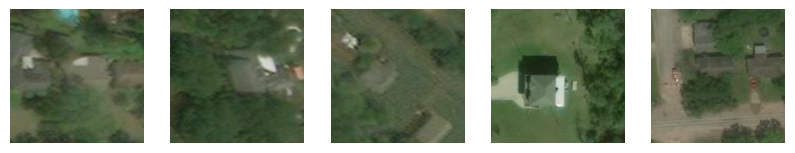

In [10]:
import matplotlib.pyplot as plt

# Get one batch of images and labels from the rescaled dataset
for images, labels in train_rescale_ds.take(1):  
    X_train_batch = images.numpy()  # Convert to NumPy array
    y_train_batch = labels.numpy()  # Convert labels to NumPy
    break

# Plot the first 5 images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_batch[i])  # No need for uint8 conversion since values are [0,1]
    plt.axis("off")

print('Label for each of the above images:', y_train_batch[:5])


In [11]:
# # creating ANN model
# def create_perceptron(dim):
#     """
#     Create a perceptron of dimension `dim` and initialize it with random weights.
#     """
#     # we use dim+1 because we want to have a bias term and `dim` weights
#     return np.random.random(dim+1)

In [12]:
# def create_layer(num_perceptrons, dim, activation_function):
#     """
#     Create a layer of `num_perceptrons` perceptron, each of dimension `dim` with activation function `activation_function`.
#     Initialize the weights of all perceptrons to a random float between 0 and 1.
#     """
#     # represent the layer as a list of dictionary of perceptrons
#     layer = []
#     for i in range(num_perceptrons):
#         layer.append({"weights": create_perceptron(dim), "activation_function": activation_function})
#     return layer

In [13]:
# try different layers and perceptrons to choose the best combination for accuracy

# case 1 (one layer)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flatten the image (150x150 RGB)
    Dense(128, activation='relu'),  # Hidden layer with ReLU
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8640257 (32.96 MB)
Trainable params: 8640257 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Train the model
history = model.fit(
    train_rescale_ds,
    validation_data=val_rescale_ds,
    epochs=15,  # Can be adjusted
    batch_size=32,
    verbose=1
)


Epoch 1/15
533/533 [==============================] - 32s 60ms/step - loss: 1.5555 - accuracy: 0.6327 - val_loss: 0.8288 - val_accuracy: 0.6207
Epoch 2/15
533/533 [==============================] - 32s 60ms/step - loss: 0.9501 - accuracy: 0.6594 - val_loss: 0.6068 - val_accuracy: 0.7478
Epoch 3/15
533/533 [==============================] - 32s 60ms/step - loss: 0.7899 - accuracy: 0.6792 - val_loss: 0.6315 - val_accuracy: 0.7227
Epoch 4/15
533/533 [==============================] - 32s 60ms/step - loss: 0.6031 - accuracy: 0.7149 - val_loss: 0.5809 - val_accuracy: 0.7366
Epoch 5/15
533/533 [==============================] - 32s 60ms/step - loss: 0.6298 - accuracy: 0.7081 - val_loss: 0.7778 - val_accuracy: 0.6695
Epoch 6/15
533/533 [==============================] - 32s 60ms/step - loss: 0.5642 - accuracy: 0.7296 - val_loss: 0.5486 - val_accuracy: 0.7277
Epoch 7/15
533/533 [==============================] - 32s 60ms/step - loss: 0.5496 - accuracy: 0.7346 - val_loss: 0.8950 - val_accuracy:

In [15]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_rescale_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


491/491 [==============================] - 3s 7ms/step - loss: 0.5205 - accuracy: 0.7608
Test Loss: 0.5205
Test Accuracy: 0.7608


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# case 2 (two layers, adjusted perceptron count)

# Define the model
model2 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flatten the image (150x150 RGB)
    Dense(512, activation='relu'),  # Hidden layer with ReLU
    Dense(256, activation='relu'),   # Another hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model2.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

# Print model summary
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 67500)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               34560512  
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34692097 (132.34 MB)
Trainable params: 34692097 (132.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Train the model
history = model2.fit(
    train_rescale_ds,
    validation_data=val_rescale_ds,
    epochs=15,  # Can be adjusted
    batch_size=32,
    verbose=1
)


Epoch 1/15
533/533 [==============================] - 114s 213ms/step - loss: 1.1787 - accuracy: 0.6424 - val_loss: 0.6353 - val_accuracy: 0.6179
Epoch 2/15
533/533 [==============================] - 112s 210ms/step - loss: 0.5898 - accuracy: 0.7054 - val_loss: 0.6247 - val_accuracy: 0.6371
Epoch 3/15
533/533 [==============================] - 111s 208ms/step - loss: 0.6015 - accuracy: 0.6816 - val_loss: 0.6515 - val_accuracy: 0.6498
Epoch 4/15
533/533 [==============================] - 112s 210ms/step - loss: 0.6042 - accuracy: 0.6676 - val_loss: 0.6401 - val_accuracy: 0.6498
Epoch 5/15
533/533 [==============================] - 111s 208ms/step - loss: 0.6215 - accuracy: 0.6648 - val_loss: 0.6457 - val_accuracy: 0.6498
Epoch 6/15
533/533 [==============================] - 111s 209ms/step - loss: 0.6005 - accuracy: 0.6690 - val_loss: 0.6479 - val_accuracy: 0.6498
Epoch 7/15
533/533 [==============================] - 111s 208ms/step - loss: 0.6115 - accuracy: 0.6684 - val_loss: 0.5800 -

In [18]:
# Evaluate on test set
test_loss, test_acc = model2.evaluate(test_rescale_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


491/491 [==============================] - 7s 14ms/step - loss: 0.6020 - accuracy: 0.6725
Test Loss: 0.6020
Test Accuracy: 0.6725


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# case 3 (3 layers)

# Define the model
model3 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flatten the image (150x150 RGB)
    Dense(512, activation='relu'),  # Hidden layer with ReLU
    Dense(256, activation='relu'),   # Another hidden layer
    Dense(128, activation='relu'),   # Another hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model3.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

# Print model summary
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 67500)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               34560512  
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34724865 (132.46 MB)
Trainable params: 34724865 (132.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Train the model
history = model3.fit(
    train_rescale_ds,
    validation_data=val_rescale_ds,
    epochs=15, 
    batch_size=32,
    verbose=1
)


Epoch 1/15
533/533 [==============================] - 112s 208ms/step - loss: 1.0217 - accuracy: 0.6513 - val_loss: 0.5930 - val_accuracy: 0.6901
Epoch 2/15
533/533 [==============================] - 112s 209ms/step - loss: 0.5881 - accuracy: 0.7040 - val_loss: 0.5699 - val_accuracy: 0.7054
Epoch 3/15
533/533 [==============================] - 112s 209ms/step - loss: 0.6219 - accuracy: 0.6783 - val_loss: 0.6477 - val_accuracy: 0.6498
Epoch 4/15
533/533 [==============================] - 111s 209ms/step - loss: 0.6361 - accuracy: 0.6683 - val_loss: 0.6481 - val_accuracy: 0.6498
Epoch 5/15
533/533 [==============================] - 110s 207ms/step - loss: 0.6354 - accuracy: 0.6684 - val_loss: 0.6480 - val_accuracy: 0.6498
Epoch 6/15
533/533 [==============================] - 110s 207ms/step - loss: 0.6359 - accuracy: 0.6684 - val_loss: 0.6482 - val_accuracy: 0.6498
Epoch 7/15
533/533 [==============================] - 111s 208ms/step - loss: 0.6356 - accuracy: 0.6684 - val_loss: 0.6477 -

In [21]:
# Evaluate on test set
test_loss, test_acc = model3.evaluate(test_rescale_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

491/491 [==============================] - 7s 14ms/step - loss: 0.6386 - accuracy: 0.6636
Test Loss: 0.6386
Test Accuracy: 0.6636


In [22]:
import tensorflow as tf
from tensorflow.keras import models, layers  # Following lab's import style
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

#Variant 1: Baseline LeNet-5 with 6 and 16 filters, 120 and 84 neurons.

# Define input shape and number of classes for your dataset
input_shape = (150, 150, 3)  # Your 150x150 RGB images
num_classes = 2  # damage/no-damage
model_lenet5 = models.Sequential()

# Layer 1
model_lenet5.add(layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Layer 2
model_lenet5.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

model_lenet5.add(layers.Flatten())  

# Layer 3
model_lenet5.add(layers.Dense(120, activation='relu'))

# Layer 4
model_lenet5.add(layers.Dense(84, activation='relu'))

# Output layer
model_lenet5.add(layers.Dense(num_classes, activation='softmax'))

model_lenet5.compile(optimizer=RMSprop(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
model_lenet5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 73, 73, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 34, 34, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_3 (Flatten)         (None, 18496)             0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [23]:
# Fit the model using your preprocessed datasets
history = model_lenet5.fit(
    train_rescale_ds,
    batch_size=32,  # Matches your dataset's batch size
    epochs=20,      # Matches lab's epoch count
    validation_data=val_rescale_ds
)

Epoch 1/20
533/533 [==============================] - 79s 146ms/step - loss: 0.5422 - accuracy: 0.7370 - val_loss: 0.4457 - val_accuracy: 0.8189
Epoch 2/20
533/533 [==============================] - 78s 146ms/step - loss: 0.4235 - accuracy: 0.8199 - val_loss: 0.3738 - val_accuracy: 0.8520
Epoch 3/20
533/533 [==============================] - 77s 145ms/step - loss: 0.3778 - accuracy: 0.8438 - val_loss: 0.4155 - val_accuracy: 0.8051
Epoch 4/20
533/533 [==============================] - 77s 145ms/step - loss: 0.3400 - accuracy: 0.8601 - val_loss: 0.3271 - val_accuracy: 0.8651
Epoch 5/20
533/533 [==============================] - 77s 144ms/step - loss: 0.3053 - accuracy: 0.8728 - val_loss: 0.2942 - val_accuracy: 0.8794
Epoch 6/20
533/533 [==============================] - 78s 146ms/step - loss: 0.2745 - accuracy: 0.8863 - val_loss: 0.2612 - val_accuracy: 0.8919
Epoch 7/20
533/533 [==============================] - 78s 146ms/step - loss: 0.2457 - accuracy: 0.9007 - val_loss: 0.2373 - val_ac

In [24]:
# Evaluate on test set
test_loss, test_accuracy = model_lenet5.evaluate(test_rescale_ds, verbose=0)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


Test accuracy: 0.9750
Test loss: 0.0745


In [25]:
import tensorflow as tf
from tensorflow.keras import models, layers  # Following lab's import style
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt


#Variant 2: Increases filters to 12 and 32 for more feature extraction capacity.

# Define LeNet-5 with increased filters
model_lenet5 = models.Sequential()

# Layer 1
model_lenet5.add(layers.Conv2D(12, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Layer 2
model_lenet5.add(layers.Conv2D(32, kernel_size=(5, 5), activation='relu'))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

model_lenet5.add(layers.Flatten())  

# Layer 3
model_lenet5.add(layers.Dense(120, activation='relu'))

# Layer 4
model_lenet5.add(layers.Dense(84, activation='relu'))

# Output layer
model_lenet5.add(layers.Dense(num_classes, activation='softmax'))

# Compile
model_lenet5.compile(optimizer=RMSprop(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Summary
model_lenet5.summary()

# Train
history = model_lenet5.fit(
    train_rescale_ds,
    batch_size=32,
    epochs=20,
    validation_data=val_rescale_ds,
    verbose=1
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 146, 146, 12)      912       
                                                                 
 average_pooling2d_2 (Avera  (None, 73, 73, 12)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 32)        9632      
                                                                 
 average_pooling2d_3 (Avera  (None, 34, 34, 32)        0         
 gePooling2D)                                                    
                                                                 
 flatten_4 (Flatten)         (None, 36992)             0         
                                                                 
 dense_12 (Dense)            (None, 120)              

In [26]:
# Evaluate
test_loss, test_accuracy = model_lenet5.evaluate(test_rescale_ds, verbose=0)
print(f"\nVariant 2 - Increased Filters")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


Variant 2 - Increased Filters
Test accuracy: 0.9806
Test loss: 0.0608


In [27]:
import tensorflow as tf
from tensorflow.keras import models, layers  # Following lab's import style
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt


#Variant 3: Keeps original filters but increases dense layers to 256 and 128, adding dropout (0.5) to reduce overfitting.

# Define LeNet-5 with dropout and modified dense layers
model_lenet5 = models.Sequential()

# Layer 1
model_lenet5.add(layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# Layer 2
model_lenet5.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu'))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

model_lenet5.add(layers.Flatten())  

# Layer 3
model_lenet5.add(layers.Dense(256, activation='relu'))
model_lenet5.add(layers.Dropout(0.5))  # Added dropout

# Layer 4
model_lenet5.add(layers.Dense(128, activation='relu'))
model_lenet5.add(layers.Dropout(0.5))  # Added dropout

# Output layer
model_lenet5.add(layers.Dense(num_classes, activation='softmax'))

# Compile
model_lenet5.compile(optimizer=RMSprop(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Summary
model_lenet5.summary()

# Train
history = model_lenet5.fit(
    train_rescale_ds,
    batch_size=32,
    epochs=20,
    validation_data=val_rescale_ds,
    verbose=1
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 146, 146, 6)       456       
                                                                 
 average_pooling2d_4 (Avera  (None, 73, 73, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 69, 69, 16)        2416      
                                                                 
 average_pooling2d_5 (Avera  (None, 34, 34, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_5 (Flatten)         (None, 18496)             0         
                                                                 
 dense_15 (Dense)            (None, 256)              

In [28]:
test_loss, test_accuracy = model_lenet5.evaluate(test_rescale_ds, verbose=0)
print(f"\nVariant 3 - Dropout and Modified Dense Layers")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


Variant 3 - Dropout and Modified Dense Layers
Test accuracy: 0.9687
Test loss: 0.0852


In [29]:
# adding alternate lenet-5 cnn
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

model_alt_cnn = models.Sequential()

# first block
model_alt_cnn.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_alt_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

# second block 
model_alt_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_alt_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

# third block 
model_alt_cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_alt_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

# fourth block 
model_alt_cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_alt_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

# flattening
model_alt_cnn.add(layers.Flatten())

# dense layers 
model_alt_cnn.add(layers.Dense(512, activation='relu'))

# output layer
model_alt_cnn.add(layers.Dense(2, activation='softmax'))   # not sure what num to put

model_alt_cnn.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_alt_cnn.fit(train_rescale_ds, batch_size=32, epochs=10)

Epoch 1/10
533/533 [==============================] - 159s 297ms/step - loss: 0.5430 - accuracy: 0.7430
Epoch 2/10
533/533 [==============================] - 157s 294ms/step - loss: 0.3769 - accuracy: 0.8419
Epoch 3/10
533/533 [==============================] - 157s 294ms/step - loss: 0.2908 - accuracy: 0.8840
Epoch 4/10
533/533 [==============================] - 157s 295ms/step - loss: 0.2193 - accuracy: 0.9146
Epoch 5/10
533/533 [==============================] - 157s 294ms/step - loss: 0.1682 - accuracy: 0.9349
Epoch 6/10
533/533 [==============================] - 157s 295ms/step - loss: 0.1425 - accuracy: 0.9455
Epoch 7/10
533/533 [==============================] - 157s 294ms/step - loss: 0.1232 - accuracy: 0.9512
Epoch 8/10
533/533 [==============================] - 158s 296ms/step - loss: 0.1103 - accuracy: 0.9579
Epoch 9/10
533/533 [==============================] - 158s 297ms/step - loss: 0.0988 - accuracy: 0.9623
Epoch 10/10
533/533 [==============================] - 158s 296m

In [30]:
model_alt_cnn.summary()
test_loss, test_accuracy = model_alt_cnn.evaluate(test_rescale_ds, verbose=0)
print("Alternate Lenet-5 CNN accuracy:", test_accuracy)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

In [35]:
# adding alternate lenet-5 cnn
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

model_alt_cnn2 = models.Sequential()

# first block
model_alt_cnn2.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_alt_cnn2.add(layers.MaxPooling2D(pool_size=(2,2)))

# second block 
model_alt_cnn2.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_alt_cnn2.add(layers.MaxPooling2D(pool_size=(2,2)))

# third block 
model_alt_cnn2.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_alt_cnn2.add(layers.MaxPooling2D(pool_size=(2,2)))

# fourth block 
model_alt_cnn2.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_alt_cnn2.add(layers.MaxPooling2D(pool_size=(2,2)))

# flattening
model_alt_cnn2.add(layers.Flatten())

# dense layers 
model_alt_cnn2.add(layers.Dense(512, activation='relu'))

# output layer
model_alt_cnn2.add(layers.Dense(2, activation='softmax'))   # not sure what num to put

model_alt_cnn2.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_alt_cnn2.fit(train_rescale_ds, batch_size=32, epochs=20)

Epoch 1/20
533/533 [==============================] - 163s 304ms/step - loss: 0.4938 - accuracy: 0.7725
Epoch 2/20
533/533 [==============================] - 163s 306ms/step - loss: 0.3334 - accuracy: 0.8654
Epoch 3/20
533/533 [==============================] - 163s 306ms/step - loss: 0.2523 - accuracy: 0.9041
Epoch 4/20
533/533 [==============================] - 162s 305ms/step - loss: 0.1875 - accuracy: 0.9274
Epoch 5/20
533/533 [==============================] - 162s 305ms/step - loss: 0.1510 - accuracy: 0.9415
Epoch 6/20
533/533 [==============================] - 163s 306ms/step - loss: 0.1284 - accuracy: 0.9495
Epoch 7/20
533/533 [==============================] - 162s 304ms/step - loss: 0.1137 - accuracy: 0.9577
Epoch 8/20
533/533 [==============================] - 162s 305ms/step - loss: 0.1022 - accuracy: 0.9595
Epoch 9/20
533/533 [==============================] - 163s 307ms/step - loss: 0.0946 - accuracy: 0.9632
Epoch 10/20
533/533 [==============================] - 164s 307m

In [43]:
model_alt_cnn2.summary()
test_loss, test_accuracy = model_alt_cnn2.evaluate(test_rescale_ds, verbose=0)
print("Alternate Lenet-5 CNN accuracy:", test_accuracy)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [47]:
model_alt_cnn2.save('./models/model_alt_cnn2.keras')

Labels for these images: [0 0 1 1 0]


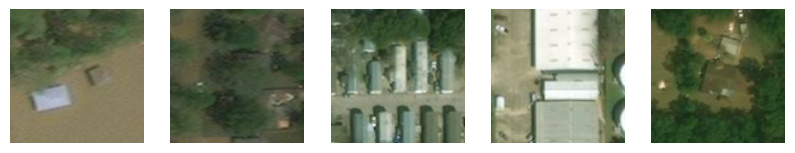

In [48]:
for images, labels in train_rescale_ds.take(1):
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])  # Display image
        plt.axis("off")
    print('Labels for these images:', labels.numpy()[:5])  # Print labels


In [49]:
for image, label in test_rescale_ds.take(1):  # Get a batch from the test dataset
    prediction = model_alt_cnn2.predict(image)
    print("Prediction:", prediction)
    print("True label:", label)


1/1 [==============================] - 0s 181ms/step
Prediction: [[2.37326859e-03 9.97626662e-01]
 [9.59411128e-09 9.99999940e-01]
 [8.08362722e-01 1.91637248e-01]
 [9.99997795e-01 2.18254445e-06]
 [4.22799644e-08 9.99999940e-01]
 [1.83407159e-04 9.99816656e-01]
 [9.99999940e-01 4.36435393e-12]
 [9.99998748e-01 1.13530484e-06]
 [9.99967873e-01 3.20864092e-05]
 [9.99966919e-01 3.29699651e-05]
 [9.99986351e-01 1.36074859e-05]
 [3.57534154e-04 9.99642551e-01]
 [9.99981344e-01 1.86309644e-05]
 [9.97550607e-01 2.44938210e-03]
 [5.78308245e-05 9.99942124e-01]
 [9.99997079e-01 2.89582590e-06]
 [9.99999821e-01 1.68316788e-07]
 [9.99998987e-01 9.64945229e-07]
 [1.98023417e-03 9.98019755e-01]
 [9.99997437e-01 2.55076634e-06]
 [1.02754916e-06 9.99998868e-01]
 [9.99737740e-01 2.62185815e-04]
 [8.83286372e-02 9.11671340e-01]
 [9.99991000e-01 8.99086717e-06]
 [9.99999940e-01 4.71393202e-10]
 [9.99894798e-01 1.05128696e-04]
 [1.29456230e-05 9.99986947e-01]
 [9.99667823e-01 3.32140044e-04]
 [9.9999994

In [54]:
import numpy as np
prediction = model_alt_cnn2.predict(image)
predicted_class = np.argmax(prediction, axis=1)  # This will give you the index (0 or 1)
for image, label in test_rescale_ds.take(1):
    for i in range (5):
        prediction = model_alt_cnn2.predict(image)
        predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class (0 or 1)
        true_label = label.numpy()[0]  # Get the true label for the image
    
        print(f"Prediction: {prediction[0]}, Predicted class: {predicted_class}, True label: {true_label}")


1/1 [==============================] - 0s 122ms/step
Prediction: [0.00157682 0.9984232 ], Predicted class: 1, True label: 1
1/1 [==============================] - 0s 94ms/step
Prediction: [0.00157682 0.9984232 ], Predicted class: 1, True label: 1
1/1 [==============================] - 0s 110ms/step
Prediction: [0.00157682 0.9984232 ], Predicted class: 1, True label: 1
1/1 [==============================] - 0s 114ms/step
Prediction: [0.00157682 0.9984232 ], Predicted class: 1, True label: 1
1/1 [==============================] - 0s 94ms/step
Prediction: [0.00157682 0.9984232 ], Predicted class: 1, True label: 1


Labels for this batch: [0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


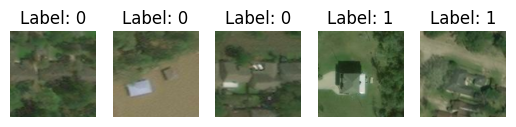

In [55]:
for images, labels in train_rescale_ds.take(1):  # Take the first batch
    # Print out the labels for the batch
    print("Labels for this batch:", labels.numpy())  # This prints the labels
    # Print the image and its corresponding label
    for i in range(5):  # Print first 5 images
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])  # Display the image
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()
